<a id='top'></a>

# CSCI 3202, Spring 2018
# Assignment 3
# Due:  Wednesday 28 February 2018 by 12:00 PM

<br>

### Your name:

<br>

**Note:** Some packages to load, helper functions and unit tests are defined at [the bottom of this notebook](#helpers)

Shortcuts:  [top](#top) || [1](#p1) | [1a](#p1a) | [1b](#p1b) | [1c](#p1c) | [1d](#p1d) | [1e](#p1e) || [2](#p2) | [2a](#p2a) | [2b](#p2b) | [2c](#p2c) | [2d](#p2d) | [2e](#p2e) | [2f](#p2f) || [helpers](#helpers)

---

<a id='p1'></a>[Back to top](#top)

## Problem 1

### Still trying to Escape from Chicago

Well, it turns out Snake lived through his perilous trip to New York City.  He returned to Chicago, where he is living happily among the criminals, sea lions and criminal sea lions.

During Snake's time on the east coast, he came to realize that the soothing Atlantic Ocean air does wonders for his nerves. Living in the penal colony of Chicago is just so stressful! So he has decided to pack up and move to Providence, Rhode Island.

Because Snake has traveled across the country already, he has some prior knowledge regarding how far various cities along the way are from his final destination of Providence.  In particular, Snake maps out the **straight-line distance** from major cities to Providence. This information is displayed graphically below, on a tattoo on Kurt Russell's forearm (you can't prove that isn't true), and in the `sld_providence` dictionary in the [helper functions](#helper) at the bottom of this notebook.

Also note that because it doesn't make much sense to add estimated travel times and the straight-line distance, we will only be using the `map_distances` state space graph for this problem.

**map_distances**          |  **sld_providence**
:-------------------------:|:-------------------------:
<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/us_map_distances.png" style="width: 500px;"/>  | <img src="http://www.cs.colorado.edu/~tonyewong/home/resources/us_map_heuristicSLD.png" style="width: 500px;"/>


<a id='p1a'></a>
### (1a)

Modify your code for uniform-cost search from Homework 2 so that it provides optionally as output the number of nodes **expanded** in completing the search. 

Include a new optional logical (True/False) argument **return_nexp**, so your function calls to the new uniform cost search will look like: `uniform_cost(start, goal, state_graph, return_cost, return_nexp)`.
* If `return_nexp` is True, then the last output in the output tuple should be the number of nodes expanded.
* If `return_nexp` is False, then the code should behave exactly as it did in Homework 2.

Then, verify that your revised codes are working by checking Snake's optimal route from Chicago to New York. Include the number of nodes expanded and the path cost (using `map_distances`).

In [92]:
class Frontier_PQ:
    def __init__(self, start, cost):
        self.start = start
        self.cost = cost
        self.states= {}# dic of states on fronter w/ min path cost to arrive
        self.q = [] # tuple list of (cost, state)
        
    def add(self, state, cost):
        self.states[state] = cost
        heapq.heappush(self.q, (cost, state))
        return 
    
    def pop(self):
        return heapq.heappop(self.q)
    
    def replace(self, state, cost):
        del self.states[state]
        self.states[state] = cost
        return 
    


In [93]:
def uniform_cost(start, goal, state_graph, return_cost, return_nexp):
    explored = {}
    frontier = Frontier_PQ(start, 0)
    
    explored[start] = (None)
    frontier.add(start, 0)
    nexp = 0

    while frontier.q:
        
        parent = frontier.pop()[1]
#         print('ucs', parent)
        nexp += 1
        if (parent == goal):
            goalPath = path(explored, goal)
            if not return_nexp:
                return (goalPath, pathcost(goalPath, state_graph)) if return_cost else goalPath
            else:
                 return (goalPath, pathcost(goalPath, state_graph), nexp) if (return_cost, nexp) else goalPath
        
        for child in state_graph[parent]:
            if child in frontier.states:
                tempPath = {}
                tempPath[parent] = (None)
                tempPath[child] = parent
                tempPathCost = pathcost(path(tempPath, child), state_graph)

                if (frontier.states[parent] + tempPathCost < frontier.states[child]):
                    frontier.replace(child, tempPathCost + frontier.states[parent])
                    explored[child] = parent

            if child not in frontier.states:
                explored[child] = parent
                childPath = path(explored, child)
                childCost = pathcost(childPath, state_graph)
                frontier.add(child, childCost)
    return

#### Unit tests

In [94]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem1('test_ucs_route'))
tests_to_run.addTest(Tests_Problem1('test_ucs_cost'))
tests_to_run.addTest(Tests_Problem1('test_ucs_nexp'))
unittest.TextTestRunner().run(tests_to_run)

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

<br>

<a/ id='p1b'></a>

### (1b)

#### Heuristic function

Define a function to take as an argument the `state` that Snake is in (city on our graphs), and return as output the value of the straight-line distance heuristic, between Snake's `state` and Providence.  Note that your function should be quite short, and amounts to looking up the proper value from the `sld_providence` dictionary defined in the [helper functions](#helper).  Call this function `heuristic_sld_providence`.

This might seem sort of silly right now, but it will make your codes much easier to adapt in Problem 2.

In [95]:
def heuristic_sld_providence(state):
    return sld_providence[state]

#### Unit tests

In [96]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem1("test_sld_providence"))
unittest.TextTestRunner().run(tests_to_run)

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

<br>

<a/ id='p1c'></a>

### (1c)

#### Full-blown A\* search

We are finally ready to help Snake use his knowledge of straight-line distances from various cities to Providence to inform his path-finding from Chicago to Providence!

Modify your uniform-cost search codes from **(1a)** even further so that they now perform **A\* search**, using as the heuristic function the straight-line distance to Providence.

Provide `heuristic` as an additional argument, which should just be the function name to call within the A\* code. So your call to the A\* routine should look like:  `astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp)`.  (This kind of modular programming will make it much easier to swap in alternative heuristic functions later, and also helps to facilitate debugging if something goes wrong.)

In [97]:
class Frontier_PQ_astar:
    def __init__(self, start, cost):
        self.start = start
        self.cost = cost
        self.states= {} # dic of states on fronter w/ min path cost to arrive
        self.q = [] # tuple list of (cost, state)
        
    def add(self, state, cost, hcost):
        self.states[state] = cost
        heapq.heappush(self.q, (hcost + cost, state))
        return 
    
    def pop(self):
        return heapq.heappop(self.q)
    
    def replace(self, state, cost, hcost):
        del self.states[state]
        self.states[state] = cost
        heapq.heapreplace(self.q, (hcost + cost, state))
        return 

def astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp):
    explored = {}
    frontier = Frontier_PQ_astar(start, 0)
    
    explored[start] = (None)
    frontier.add(start, 0, heuristic(start))
    nexp = 0

    while frontier.q:
        parentTcost, parent = frontier.pop()
        nexp += 1
        if (parent == goal):
            goalPath = path(explored, goal)
            if not return_nexp:
                return (goalPath, pathcost(goalPath, state_graph)) if return_cost else goalPath
            else:
                return (goalPath, pathcost(goalPath, state_graph), nexp) if (return_cost, nexp) else goalPath
        
        for child in state_graph[parent]:
            
            tempPath = {}
            tempPath[parent] = (None)
            tempPath[child] = parent
            tempPathCost = pathcost(path(tempPath, child), state_graph)
            g_n = frontier.states[parent] + tempPathCost
            h_n = heuristic(child)
            f_n = g_n + h_n

            if child in frontier.states:
                if (g_n  < frontier.states[child]):
                    frontier.replace(child, g_n, h_n)
                    explored[child] = parent

            if child not in frontier.states:
                explored[child] = parent
                childPath = path(explored, child)
                childCost = pathcost(childPath, state_graph)
                frontier.add(child, childCost, h_n)
                
    return

#### Unit tests

In [98]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem1("test_astar_path"))
tests_to_run.addTest(Tests_Problem1("test_astar_cost"))
tests_to_run.addTest(Tests_Problem1("test_astar_nexp"))
unittest.TextTestRunner().run(tests_to_run)

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

<br>

<a/ id='p1d'></a>

### (1d)

Snake has already made it to Buffalo on his own, but he is growing weary.  There were ***so*** many sea lions along the way, and he had to stop and admire their grace and beauty.  Use your A\* search code from **(1c)** to help Snake find the optimal path **by distance traveled** the rest of the way to Providence.  Print to the screen the following:
1. the optimal path
2. the optimal path cost (miles traveled)
3. the number of states expanded during the A\* search

Additionally, show below how many states must be expanded to find the optimal path from Buffalo to Providence using the regular old uniform-cost search algorithm from **(1a)**.  Comment on the difference in states that must be explored by each algorithm.

**Sanity check:** No matter what your `start` and `goal` states are, how should the output from `astar_search` and `uniform_cost` search compare?

In [99]:
astar_path, astar_cost, astar_nexp = astar_search('buf','pro', map_distances, heuristic_sld_providence, return_cost=True, return_nexp=True)
print('Optimal Path:', astar_path)
print('Path cost is', astar_cost, 'miles')
print('# of states expanded by A* is', astar_nexp)
usc_path, usc_cost, usc_nexp = uniform_cost('buf','pro',map_distances, return_cost=True, return_nexp=True)
print('# of states expanded by UCS is',usc_nexp)

Optimal Path: ['buf', 'syr', 'bos', 'pro']
Path cost is 512 miles
# of states expanded by A* is 4
# of states expanded by UCS is 14


##### The number of states expanded by UCS is much higher than that of astar_search (as it should be). astar_search has its restriction on what states are to be expanded on next using our heuristic function compared to uniform_cost which just goes crazy and expands all over the place.

<br>

<a/ id='p1e'></a>

### (1e)

How many states are expanded by each of A\* search and uniform cost search, to find the optimal path **from Philadelphia to Providence**?

In [100]:
astar_path, astar_cost, astar_nexp = astar_search('phi','pro', map_distances, heuristic_sld_providence, return_cost=True, return_nexp=True)
usc_path, usc_cost, usc_nexp = uniform_cost('phi','pro',map_distances, return_cost=True, return_nexp=True)
print('states expanded by A* search is', astar_nexp)
print('states expanded by USC is', usc_nexp)

states expanded by A* search is 3
states expanded by USC is 5


You should find that uniform cost search has explored more states than A\* search.  Name the city/cities corresponding to the additional state expansions, and a brief justification for how you know these are being explored.

#### The additional state expansions in UCS are in `Baltimore` and in `Syracuse` I know these are the states being explored because we can throw in a simple print statement right after a state is being popped off of the Frontier to be explored. Comparing the states being popped off the frontier by each algorithm gives us the additional state expansions for UCS.

<br>

---

<br>

[Back to top](#top)

<a/ id='p2'></a>

![8tile](http://www.8puzzle.com/images/8_puzzle_goal_state_b.png)

## Problem 2

### 8-tile puzzle

Consider the 8-tile puzzle, as discussed in class.  The goal state is illustrated in the figure above, and the rest of the state space is obtained by sliding a numbered tile in the plane of the puzzle into the blank spot.  We can use a 0 to represent the blank space, and represent the state of an 8-tile puzzle board as a `numpy` array as follows:

In [101]:
goal = np.array([[0,1,2],[3,4,5],[6,7,8]])
print('Goal state is:\n{}'.format(goal))

Goal state is:
[[0 1 2]
 [3 4 5]
 [6 7 8]]


<br>

<a/ id='p2a'></a>

### (2a)

Design two heuristic functions to return the **Manhattan distance** heuristic and the **number of misplaced tiles** heuristic.  These functions should be called `heuristic_manhattan` and `heuristic_misplaced`, and:
* take two `numpy` array arguments, `state` and `goal`
* `state` is the current state of an 8-tile board,
* `goal` is the goal state to measure against,
* return the appropriate heuristic value (Manhattan distance or misplaced tiles) for the estimated distance of the given `state` to the `goal`

In [102]:
def heuristic_manhattan(state, goal):
    distance = 0
    goal_dict = {}
    state_dict = {}
    
    for (x,y), value in np.ndenumerate(goal):
        goal_dict[value] = (x,y)
        
    for (x,y), value in np.ndenumerate(state):
        state_dict[value] = (x,y)
        
    for elm in state_dict:
        if state_dict[elm] != goal_dict[elm]:
            if (state_dict[elm][0] != goal_dict[elm][0]): # Get difference in rows
                distance += abs(state_dict[elm][0] - goal_dict[elm][0])
                
            if (state_dict[elm][1] != goal_dict[elm][1]): # Get difference in columns
                distance += abs(state_dict[elm][1] - goal_dict[elm][1])
    return distance

def heuristic_misplaced(state, goal):
    misplaced = 0
    for (x,y), value in np.ndenumerate(state):
        if state[x][y] != goal[x][y]:
            misplaced += 1
    return misplaced


#### Unit tests

In [103]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem2("test_manhattan"))
tests_to_run.addTest(Tests_Problem2("test_misplaced"))
unittest.TextTestRunner().run(tests_to_run)

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<br>

<a/ id='p2b'></a>

### (2b)

#### Is this puzzle even solvable??

It turns out that some arrangements of those 8 tiles are not possible to solve into the `goal` state given above. We would like to be able to check whether or not a given 8-tile puzzle board is solvable.

Suppose you take the tiles of any given 8-tile puzzle board and arranged them in a single row, with the first row coming in order first, then the second row in order, and finally the third row in order.  So the goal state would be [1,2,3,4,5,6,7,8]. Another possible state is:

In [104]:
state_test = np.array([[1,4,2],[3,0,5],[6,7,8]])
print(state_test)

[[1 4 2]
 [3 0 5]
 [6 7 8]]


The state `state_test` is found by sliding the 1 tile to the blank spot, then sliding the 4 tile up to take the position formerly occupied by the 1 tile.  When we rearrange this state into a row, we obtain [1,4,2,3,5,6,7,8].

We define an **inverted tile pair** to be a pair of tiles in the row representation of the puzzle that is out of order relative to the goal state. That is, each occurrence of a tile that has a higher value than another tile later in the row counts as an inversion.  So `state_test` has **two** inversions:  4 and 2, and 4 and 3.

We define the **parity** of an 8-tile board to be the number of inversions in the puzzle board.  So the parity of `state_test` is 2, and the parity of `goal` is 0. An 8-tile puzzle board may be rearranged (within the rules of the game) into another board if the two boards have the same parity. So it would be very handy if we had a function to check whether or not an arbitrary arrangement of those 8 tiles can be solved for a given `goal` state.

Write a function `check_parity(state1, state2)`:
* take as arguments two `numpy` arrays representing 8-tile boards, `state1` and `state2`
* return `True` if the two boards have the same parity and `False` otherwise

In [105]:
def get_parity(state):
    inversions=0
    yValues = state.shape[0]
    xValues = state.shape[1]
    for (i,j), runner in np.ndenumerate(state):
        for (x,y), val in np.ndenumerate(state):
            if (x > i or (x==i and y >=j)): 
                if runner > val and (runner != 0 and val != 0):
                    inversions += 1
    return (inversions % 2)

def check_parity(state1, state2):
    parity1 = get_parity(state1)
    parity2 = get_parity(state2)
    return (parity1 == parity2)

#### Unit tests

In [106]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem2("test_parity_true"))
tests_to_run.addTest(Tests_Problem2("test_parity_false"))
unittest.TextTestRunner().run(tests_to_run)

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<br>

<a/ id='p2c'></a>

### (2c)

Because your instructor is such a swell guy, the `map_distances` and `map_times` graphs were nicely defined. This meant that finding the successors of a given city in the route-finding homework problems amounted to looking up the values of that key in a dictionary. For the 8-tile problem, however, we do **not** want to try to build the entire state space graph in memory! Even if we can, it's just such a pain.

Instead, let's write a function `adjacent_states`:
* take a single input argument `state`, which is a `numpy` array representing an 8-tile board arrangement
* return as output a list of `numpy` arrays that are the states one move away from the input `state`

For example, if you run `adjacent_states(goal)`, the expected output should be

`[array([[3, 1, 2], [0, 4, 5], [6, 7, 8]]),
 array([[1, 0, 2], [3, 4, 5], [6, 7, 8]])]`

which are the states obtained from the `goal` state by sliding the 3 tile up and by sliding the 1 tile to the left, respectively.

In [107]:
def swap(tmp_state, i1, i2):
    tmp = tmp_state[i1]
    tmp_state[i1] = tmp_state[i2]
    tmp_state[i2]= tmp
    return tmp_state

def adjacent_states(state):
    dic = {}
    ylim = state.shape[1]
    xlim = state.shape[0]
    moves = []
    for (x,y), value in np.ndenumerate(state):
        dic[value] = (x,y)
    
    (e1,e2) = dic[0]
    if (e1-1 >= 0): #check top tile
        tmp_state = np.array(state, copy=True)
        new_move = swap(tmp_state, (e1-1, e2),(e1, e2))
        moves.append(new_move)
        
    if (e1+1 < ylim): #check bottom tile
        tmp_state = np.array(state, copy=True)
        new_move = swap(tmp_state, (e1+1, e2),(e1, e2))
        moves.append(new_move)
        
    if (e2-1 >= 0): # check left tile
        tmp_state = np.array(state, copy=True)
        new_move = swap(tmp_state, (e1, e2-1),(e1, e2))
        moves.append(new_move)
        
    if (e2+1 < xlim): # Check right tile
        tmp_state = np.array(state, copy=True)
        new_move = swap(tmp_state, (e1, e2+1),(e1, e2))
        moves.append(new_move)
        
    return moves

#### Unit tests

In [108]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem2("test_adjacent"))
unittest.TextTestRunner().run(tests_to_run)

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

<br>

<a/ id='p2d'></a>

### (2d)

Modify your **A\* search** from above so that instead of looking in the graphs `map_distances` or `map_times` for the successor states, it generates them on the fly using your shiny new `adjacent_states` routine from **(2c)**. 

Some notes:
* You may run into some problems with using the `numpy` arrays to represent states. One potential solution is to convert these arrays to/from tuples, as needed. This is not the only solution.
* When you start to test your code, be sure to begin with simple test cases that you know are only a few moves away from the goal state.
* Be sure to implement a check to make sure the initial state is solvable for the given goal state!  And do not hard-code the goal state given above.
* You may need to modify how path costs are added up and returned. The returned cost of the solution path ought to be the number of **moves** needed to solve the puzzle, which is one less than the number of states on the solution path.
* Depending on how you implemented your Frontier Priority Queue, you may or may not need to make modifications to it. My implementation did not require any modification.

In [137]:
def getTuple(nparray):
    return tuple(map(tuple, nparray))

def getNarray(Tuple):
    return np.asarray(Tuple)

class Frontier_PQ_astar:
    def __init__(self, start, cost):
        self.start = start
        self.cost = cost
        self.states= {} # dic of states on fronter w/ min path cost to arrive
        self.q = [] # tuple list of (cost, state)
        
    def add(self, state, cost, hcost):
        self.states[state] = cost
        heapq.heappush(self.q, (hcost + cost, state))
        return 
    
    def pop(self):
        return heapq.heappop(self.q)
    
    def replace(self, state, cost, hcost):
        del self.states[state]
        self.states[state] = cost
        heapq.heapreplace(self.q, (hcost + cost, state))
        return 

def astar_search(start, goal, heuristic, return_cost, return_nexp):
    if not(check_parity(start, goal)): # parity check
        print('Not Solvable!')
        return 
    
    start_tuple = getTuple(start) # Turn np arrays to tuples for dictionaries
    goal_tuple = getTuple(goal)
    
    explored = {}
    frontier = Frontier_PQ_astar(start_tuple, 0)
    
    explored[start_tuple] = (None)
    frontier.add(start_tuple, 0, heuristic(start_tuple, goal_tuple))
    nexp = 0

    while frontier.q:
        parentTcost, parent = frontier.pop() #tuple at this point
        nexp += 1
        

        if (parent == goal_tuple):
            goalPath = path(explored, goal_tuple)
            if not return_nexp:
                return (goalPath, len(goalPath)-1) if return_cost else goalPath
            else:
                return (goalPath, len(goalPath)-1, nexp) if (return_cost, nexp) else goalPath
        
       
        parentArray = getNarray(parent)
        moves  = adjacent_states(parentArray)
        for move in moves:
            move_tuple = getTuple(move)
            if move_tuple not in explored: # we havent made this move before
                tempPath = {}
                tempPath[parent] = (None)
                tempPath[move_tuple] = parent
                g_n = frontier.states[parent] + 1 # plus one for parent to child
                h_n = heuristic(move_tuple, goal_tuple)
                f_n = g_n + h_n

                if move_tuple in frontier.states:
                    if (g_n < frontier.states[move_tuple]):
                        frontier.replace(move_tuple, g_n, h_n)
                        explored[move_tuple] = parent
                if move_tuple not in frontier.states:
                    explored[move_tuple] = parent
                    childCost = len(explored) - 1
                    frontier.add(move_tuple, childCost, h_n)
    return 




#### Unit tests

Note that this will fail if your output path (first output slot) is not one of (1) a list of tuples, or (2) a list of `numpy` arrays.

In [138]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem2("test_astar_8tile"))
unittest.TextTestRunner().run(tests_to_run)

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

<br>

<a/ id='p2e'></a>

### (2e)

#### We need to generate some puzzles to test this out!

Create a function `generate_puzzle(goal, n_moves)` to generate a solvable 8-tile puzzle by making `n_moves` random moves, starting from the `goal` state.
* `goal` argument is a `numpy` array representing a valid 8-tile puzzle
* `n_moves` is a positive integer argument.  For each of `n_moves` iterations, generate the set of all legal 8-tile puzzle moves (you might already have a nice function for this...) and select one at random.
* When you generate the set of possible adjacent states to move to, remove any of the previous states from the list of possibilities.  This will avoid "undoing" any of the moves you've made to mix up the tiles, which is important because the point of this function is to generate tough puzzles for our codes to solve.
* return as output a tuple:
  * first element is the puzzle itself (as a `numpy` array)
  * second element is the list of previous states, so you can see the list of moves made to generate this puzzle.  This will be helpful for checking if our A\* codes are finding the correct solutions.

In [139]:
def delete(array, elm):
    new_array = []
    for each in array:
        if not (each ==elm).all():
            new_array.append(each)
    return new_array

def generate_puzzle(goal, n_moves):
    if n_moves == 0:
        return (goal, [])
    
    goalTuple = getTuple(goal)
    
    prev_states = {}
    prev_states[goalTuple] = None
    
    parent = goal
    parentTuple = goalTuple
    
    for move in range(0, n_moves):
        possible_moves = adjacent_states(parent)
        if len(possible_moves)-1 ==0:
            choice = 0
        else:
            choice = np.random.choice(len(possible_moves)-1, 1)[0]

        new_state = possible_moves[choice]
        new_state_tuple = getTuple(new_state)
          
        while new_state_tuple in prev_states:
            possible_moves = delete(possible_moves, new_state)
            if (len(possible_moves)-1 == 0):
                choice = 0
            else:
                choice = np.random.choice(len(possible_moves)-1, 1)[0]
        
            new_state = possible_moves[choice]
            new_state_tuple = getTuple(new_state)
        
        prev_states[new_state_tuple] = parentTuple
        parent = new_state
        parentTuple = getTuple(parent)
        
    return (parent, prev_states)
    
   

**Important question:** If you generate more complex puzzles (think 20 or more moves), there's a nontrivial probability that your A\* search routine will be able to find a solution in *fewer* moves than the `n_moves` argument you supplied to `generate_puzzle` to create that very puzzle.
1. Verify that this is the case with at least one example.
2. Explain why this is the case.

In [140]:
state_goal = np.array([[1,4,2],[6,3,5],[0,7,8]])

state_puzzle, prev_states = generate_puzzle(state_goal, 20)
solution, cost = astar_search(state_puzzle, state_goal, heuristic_manhattan, return_cost=True, return_nexp=False)
print('n_moves:', 20)
print('Solution moves was', cost)


n_moves: 20
Solution moves was 10


##### This is the case because our A* Search function was designed to optimally find the solution path to the goal given the start states. Our n_moves when generating our puzzle was completely chosen at random with no idea of optimization in mind.

#### Unit tests

Note that these won't work unless your A\* search and heuristic functions are working.

In [141]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem2("test_generate1"))
tests_to_run.addTest(Tests_Problem2("test_generate2"))
unittest.TextTestRunner().run(tests_to_run)

..
----------------------------------------------------------------------
Ran 2 tests in 0.030s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<br>

<a/ id='p2f'></a>

### (2f)

Generate 8-tiles puzzles varying in complexity in number of moves for the optimal solution, ranging from 10 moves to at least 25 moves.  Solve each puzzle twice using A\* search:  once using the Manhattan distance heuristic, and once using the misplaced tiles heuristic.  Keep track of:
1. the number of moves in the optimal solution path for each puzzle,
2. the number of states explored by A\* search using the Manhattan distance heuristic, and
3. the number of states explored by A\* search using the number of misplaced tiles heuristic.

In light of your answer to **(2e)**, it might be difficult to reliably generate the more complex puzzles.  As long as there are at least two puzzles that require at least 20 moves to solve, you have satisfied the problem requirements.

Note that you could put some `while` loops in here (for example) to make sure you get puzzles with all of the requisite solution path lengths. I don't really care if you do or not.

In [144]:
state_goal = np.array([[1,4,2],[6,3,5],[0,7,8]])

solution1 = []
solution2 = []
i = 10
while i < 50:
    
    puzzle = generate_puzzle(state_goal, i)[0]
    sol_path1, num_mov1, explr1 = astar_search(puzzle, state_goal, heuristic_manhattan, return_cost=True, return_nexp=True)
    sol_path2, num_mov2, explr2 = astar_search(puzzle, state_goal, heuristic_misplaced, return_cost=True, return_nexp=True)

    solution1.append((num_mov1, explr1))
    solution2.append((num_mov2, explr2))
    
    i += 1

print('Done.')

Done.


Now generate a plot of the number of states explored by A\* search using each heuristic, as a function of the number of moves along the optimal solution path. Be sure to label everything clearly.  Write a sentence or two to comment on what you notice, and whether or not it is consistent with what we saw in class.

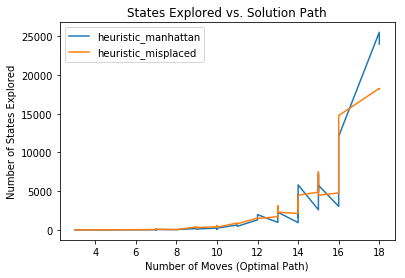

In [146]:
sorted_sol1 = sorted(solution1, key=lambda tup: tup[0])
sorted_sol2 = sorted(solution2, key=lambda tup: tup[0])

moves1, explored1 = zip(*sorted_sol1)
moves2, explored2 = zip(*sorted_sol2)

plt.plot(moves1, explored1, label='heuristic_manhattan')
plt.plot(moves2, explored2, label='heuristic_misplaced')
plt.xlabel('Number of Moves (Optimal Path)')
plt.ylabel('Number of States Explored')
plt.title('States Explored vs. Solution Path')
plt.legend()
plt.show()

<br><br><br>

<a id='helpers'></a>

---

[Back to top](#top)

## Some things that might be useful

Easiest way to start:  Click this cell, go to "Cell" in the toolbar above, and click "Run All Below"

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import unittest

## Potentially useful for searching

In [90]:
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

def pathcost(path, step_costs):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

map_distances = dict(
    chi=dict(det=283, cle=345, ind=182),
    cle=dict(chi=345, det=169, col=144, pit=134, buf=189),
    ind=dict(chi=182, col=176),
    col=dict(ind=176, cle=144, pit=185),
    det=dict(chi=283, cle=169, buf=256),
    buf=dict(det=256, cle=189, pit=215, syr=150),
    pit=dict(col=185, cle=134, buf=215, phi=305, bal=247),
    syr=dict(buf=150, phi=253, new=254, bos=312),
    bal=dict(phi=101, pit=247),
    phi=dict(pit=305, bal=101, syr=253, new=97),
    new=dict(syr=254, phi=97, bos=215, pro=181),
    pro=dict(bos=50, new=181),
    bos=dict(pro=50, new=215, syr=312, por=107),
    por=dict(bos=107))

sld_providence = dict(
    chi=833,
    cle=531,
    ind=782,
    col=618,
    det=596,
    buf=385,
    pit=458,
    syr=253,
    bal=325,
    phi=236,
    new=157,
    pro=0,
    bos=38,
    por=136)

## Unit tests

In [91]:
class Tests_Problem1(unittest.TestCase):
    def test_ucs_route(self):
        path = uniform_cost('chi','new',map_distances,return_cost=False,return_nexp=False)
        self.assertEqual(path, ['chi', 'cle', 'pit', 'phi', 'new'])
    def test_ucs_cost(self):
        path, cost = uniform_cost('chi','new',map_distances,return_cost=True,return_nexp=False)
        self.assertEqual(cost, 881)
    def test_ucs_nexp(self):
        path, cost, nexp = uniform_cost('chi','new',map_distances,return_cost=True,return_nexp=True)
        self.assertEqual(nexp, 11)
    def test_sld_providence(self):
        sld = heuristic_sld_providence('chi')
        self.assertEqual(sld, 833)
    def test_astar_path(self):
        path = astar_search('pit','pro', map_distances, heuristic_sld_providence, return_cost=False, return_nexp=False)
        self.assertEqual(path, ['pit', 'phi', 'new', 'pro'])
    def test_astar_cost(self):
        path, cost = astar_search('pit','pro', map_distances, heuristic_sld_providence, return_cost=True, return_nexp=False)
        self.assertEqual(cost, 583)
    def test_astar_nexp(self):
        path, cost, nexp = astar_search('pit','pro', map_distances, heuristic_sld_providence, return_cost=True, return_nexp=True)
        self.assertEqual(nexp, 5)
        

class Tests_Problem2(unittest.TestCase):
    def test_manhattan(self):
        state_test = np.array([[0,4,2],[1,3,5],[6,7,8]])
        goal = np.array([[0,1,2],[3,4,5],[6,7,8]])
        self.assertEqual(heuristic_manhattan(state_test, goal), 4)
    def test_misplaced(self):
        state_test = np.array([[0,4,2],[1,3,5],[6,7,8]])
        goal = np.array([[0,1,2],[3,4,5],[6,7,8]])
        self.assertEqual(heuristic_misplaced(state_test, goal), 3)
    def test_parity_true(self):
        state_test = np.array([[0,4,2],[1,3,5],[6,7,8]])
        goal = np.array([[0,1,2],[3,4,5],[6,7,8]])
        self.assertTrue(check_parity(state_test, goal))
    def test_parity_false(self):
        state_test = np.array([[0,2,1],[3,4,5],[6,7,8]])
        goal = np.array([[0,1,2],[3,4,5],[6,7,8]])
        self.assertFalse(check_parity(state_test, goal))
    def test_adjacent(self):
        state_test = np.array([[1,2,5],[3,0,4],[6,7,8]])
        adjacent = adjacent_states(state_test)
        adjacent_set = set()
        for k in range(len(adjacent)):
            adjacent_set.add(tuple(map(tuple,adjacent[k])))    
        answer = {((1, 0, 5), (3, 2, 4), (6, 7, 8)),
                  ((1, 2, 5), (0, 3, 4), (6, 7, 8)),
                  ((1, 2, 5), (3, 4, 0), (6, 7, 8)),
                  ((1, 2, 5), (3, 7, 4), (6, 0, 8))}
        self.assertEqual(adjacent_set, answer)
    def test_astar_8tile(self):
        goal = np.array([[0,1,2],[3,4,5],[6,7,8]])
        state_test = np.array([[1,4,2],[3,5,8],[6,7,0]])
        moves, cost, nexp = astar_search(state_test, goal, heuristic_manhattan, return_cost=True, return_nexp=True)
        # make sure the path is in tuples
        moves_tuple = []
        for k in range(len(moves)):
            moves_tuple.append(tuple(map(tuple, moves[k])))    
        self.assertEqual(moves_tuple, [((1, 4, 2), (3, 5, 8), (6, 7, 0)), 
                                       ((1, 4, 2), (3, 5, 0), (6, 7, 8)), 
                                       ((1, 4, 2), (3, 0, 5), (6, 7, 8)), 
                                       ((1, 0, 2), (3, 4, 5), (6, 7, 8)), 
                                       ((0, 1, 2), (3, 4, 5), (6, 7, 8))])
        self.assertEqual(cost, 4)
        self.assertEqual(nexp, 5)
    def test_generate1(self):
        goal = np.array([[0,1,2],[3,4,5],[6,7,8]])
        n_moves=15
        puzzle, steps = generate_puzzle(goal, n_moves)
        solution, cost, nexp = astar_search(puzzle, goal, heuristic_manhattan, return_cost=True, return_nexp=True)
        self.assertTrue(cost<=n_moves)
        self.assertTrue(len(solution)<=(n_moves+1) and len(solution)>0)
    def test_generate2(self):
        goal = np.array([[0,1,2],[3,4,5],[6,7,8]])
        puzzle, steps = generate_puzzle(goal, n_moves=0)
        self.assertTrue((puzzle==goal).all())


[Back to top](#top)